In [1]:
from SeismicReduction import *
import pickle

In [2]:
class VaeModel(ModelAgent):
    """
    Runs the VAE model to reduce the seismic data to an arbitrary sized dimension, visualised in 2 via UMAP.
    """
    def __init__(self, data):
        super().__init__(data)
        self.name = 'VAE'

    def create_dataloader(self, batch_size=32):
        """
        Create pytorch data loaders for use in vae training, testing and running.

        Parameters
        ----------
        batch_size : int
            Size of data loader batches.

        Returns
        -------
        Modifies object data loader attributes.

        """
        # create torch tensor
        assert self.input.shape[1] == 2, 'Expected a three dimensional input with 2 channels'
        X = torch.from_numpy(self.input).float()

        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

        split = ShuffleSplit(n_splits=1, test_size=0.5)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset,
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset,
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      **kwargs)

    def train_vae(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse'):
        """
        Handles the training of the vae model.

        Parameters
        ----------
        epochs : int
            Number of complete passes over the whole training set.
        hidden_size : int
            Size of the latent space of the vae.
        lr : float.
            Learning rate for the vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation

        Returns
        -------
        None

        """
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size,
                         self.input.shape)  # Inititalize the model

        # Create a gradient descent optimizer
        optimizer = optim.Adam(self.model.parameters(),
                               lr=lr,
                               betas=(0.9, 0.999))

        if self.plot_loss:
            liveloss = PlotLosses()
            liveloss.skip_first = 0
            liveloss.figsize = (16, 10)

        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch,
                       self.model,
                       optimizer,
                       self.train_loader,
                       recon_loss_method=recon_loss_method)  # Train model on train dataset
            testl = test(epoch, self.model, self.test_loader, recon_loss_method=recon_loss_method)

            if self.plot_loss:  # log train and test losses for dynamic plot
                logs = {}
                logs['' + 'ELBO'] = tl
                logs['val_' + 'ELBO'] = testl
                liveloss.update(logs)
                liveloss.draw()

    def run_vae(self):
        """
        Run the full data set through the trained vae model.

        Returns
        -------
        Modifies the zs attribute, an array of shape (number_traces, latent_space)
        """
        _, zs = forward_all(self.model, self.all_loader)
        return zs.numpy()

    def reduce(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse', plot_loss=True):
        """
        Controller function for the vae model.

        Parameters
        ----------
        epochs : int
            Number of epochs to run vae model.
        hidden_size : int
            Size of the vae model latent space representation.
        lr : float
            Learning rate for vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation
        plot_loss : bool
            Control on whether to plot the loss on vae training.

        Returns
        -------
        Modifies embedding attribute via generation of the low dimensional representation.

        """
        if hidden_size < 2:
            raise Exception('Please use hidden size > 1')

        self.plot_loss = plot_loss  # define whether to plot training losses or not
        self.create_dataloader()

        if not self.loaded_model:
            self.train_vae(epochs=epochs, hidden_size=hidden_size, lr=lr, recon_loss_method=recon_loss_method)

        self.embedding = self.run_vae()  # arbitrary dimension output from VAE

In [3]:
# load data
file_pi2 = open('./pickled/data.pickle', 'rb')
dataholder = pickle.load(file_pi2)
file_pi2.close()

In [4]:
### Processor
processor = Processor(dataholder)
input1 = processor(flatten=[True, 12, 52], normalise=True)

Processor has created an output with shape:  (25351, 2, 64)


In [5]:
vae = VaeModel(input1)

ModelAgent initialised


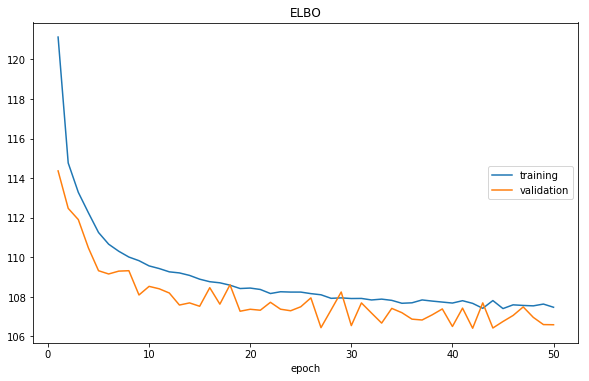

ELBO:
training   (min:  107.407, max:  121.127, cur:  107.473)
validation (min:  106.413, max:  114.364, cur:  106.590)

2D UMAP representation of VAE embedding initialised:
	Input dimension: (25351, 4)
	2-D UMAP representation complete



In [6]:
vae.reduce(epochs=50, hidden_size=4, lr=0.01, recon_loss_method='mse', plot_loss=True)
vae.to_2d(20, 0.1)

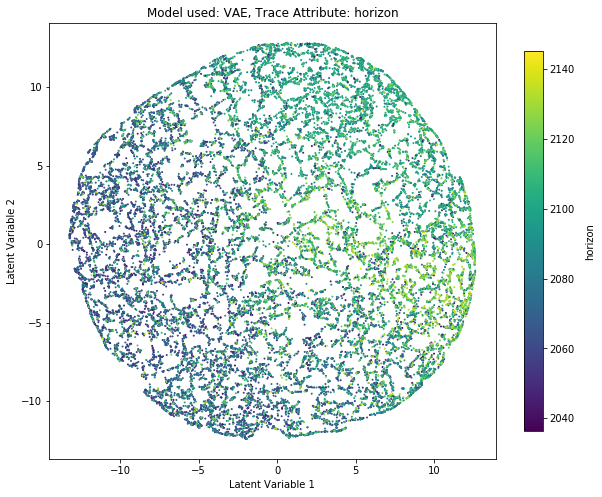

In [7]:
plot_agent(vae, attr='horizon')